# 11. Временные ряды

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [1]:
#!pip install plotly
#!pip install cufflinks

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot
import cufflinks as cf
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
cf.go_offline()

D:\Leo\DS\Anaconda\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Загрузим данные и посмотрим общую информацию о датафрейме.

In [3]:
df = pd.read_csv('taxi.csv', parse_dates = ['datetime'], index_col=['datetime'])

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В рассматриваемом датафрейме только один признак (`num_orders` - количество заказов), в качестве индексов выступают дата и время. Пропущенных значений нет, тип данных признака корректный.

Проверим, в хронологическом ли порядке располагаются индексы.

In [6]:
df.index.is_monotonic

True

Хронология индексов не нарушена, следовательно в датафрейме представлена информация о количестве заказов в аэропорт **с 1 марта 2018 года по 31 августа 2018 года**, при этом интервал выгрузки - **10 минут**.

Так как нам предстоит спрогнозировать количество заказов такси на следующий час, поэтому проведем ресемплирование - изменим интервал выгрузки с 10 минут до 1 часа. Количество заказов для каждого часа будет равно сумме заказов всех объектов датафрема внутри этого часа.

In [7]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

Загрузили данные: проверили хронологию индексов и пропущенные значения. Выполнили ресемплирование данных по одному часу.

## Анализ

Проанализируем, как меняется количество заказов с течением времени. Построим графики тренда и сезонности.

In [8]:
decomposed = seasonal_decompose(df)

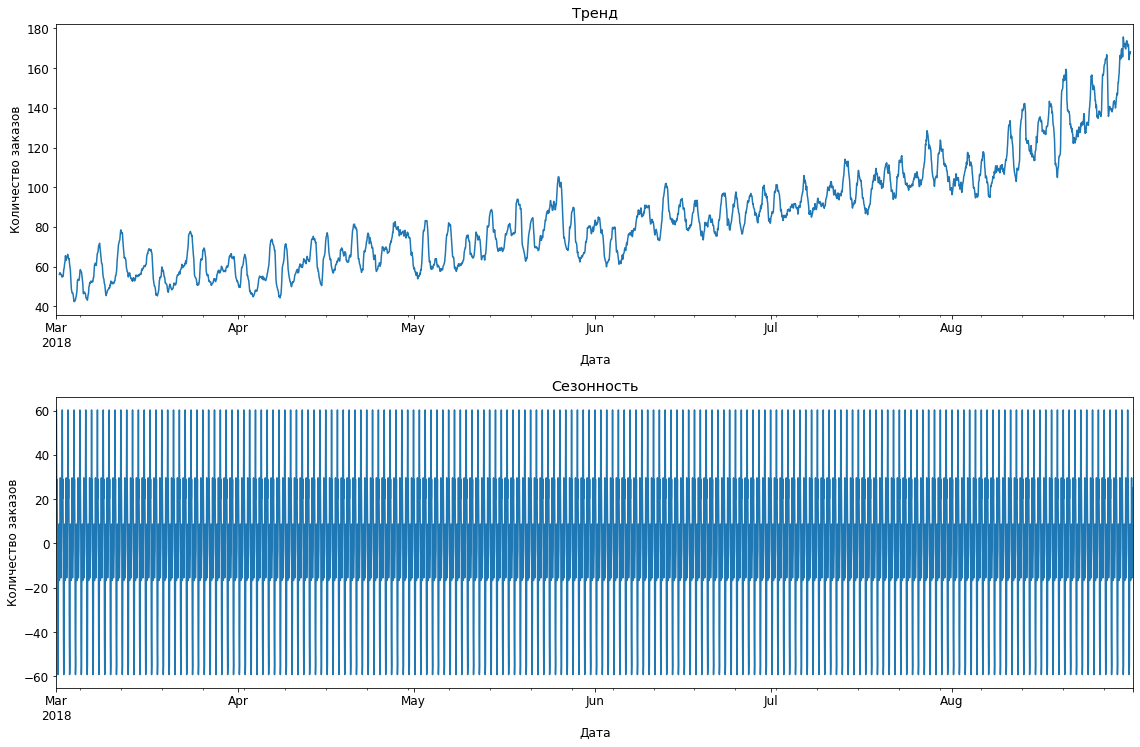

In [9]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(16, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend().remove()
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.legend().remove()
plt.show()

Виден восходящий тренд, который связан с месяцем года: чем ближе к лету, тем больше людей улетают на отдых (и возвращаются с него), и как следствие, тем больше заказов такси в аэропорт. Особенно сильный прирост наблюдается с середины июня и до конца августа.

График сезонности пока неинформативен для нас из-за малого периода. Посмотрим на сезонность в разрезе двух суток.  

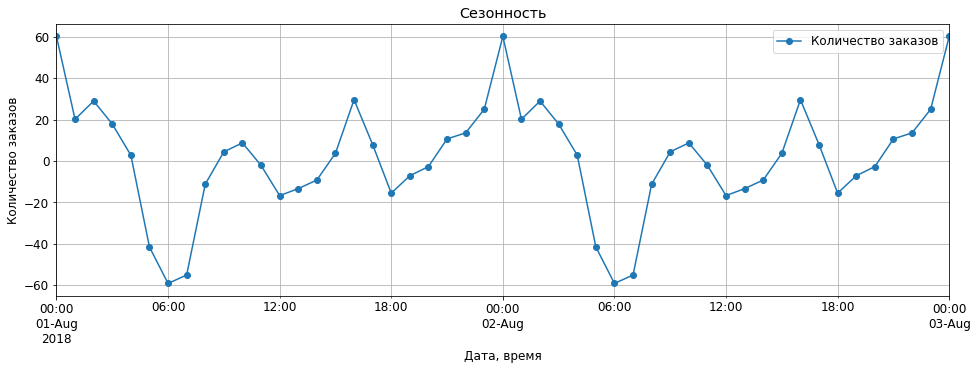

In [10]:
plt.figure(figsize=(16, 5))
decomposed.seasonal['2018-08-01':'2018-08-03 00:00:00'].plot(ax=plt.gca(), style='o-')
plt.title('Сезонность')
plt.xlabel('Дата, время')
plt.ylabel('Количество заказов')
plt.grid(which='both')
plt.legend(['Количество заказов'])
plt.show()

Замечаем, что наиболее часто такси заказывают в аэропорт с 22:00 до 03:00, наиболее редко - с 04:00 до 08:00.

Следующей зависимостью, на которую интересно посмотреть, является изменение количества заказов по дням недели. Посмотрим, в какие дни недели заказов больше и сохраняются ли эти соотношения в течение года.

Для этого создадим 2 календарных признака: месяц (`month`) и день недели (`day_of_week`). Сгруппируем заказы по дням недели и разобьем по месяцам, после этого - построим график. Для удобства, ресемплируем данные по 1 дню, но чтобы не портить исследуемый датафрейм, будем работать с его копией.

In [11]:
df1 = df.copy().resample('1D').sum()

In [12]:
df1['month'] = df1.index.month

In [13]:
df1['day_of_week'] = df1.index.dayofweek

In [14]:
(
    df1
    .pivot_table(
        index='month', 
        columns='day_of_week', 
        values='num_orders', 
        aggfunc='mean')
    .iplot(
        kind='bar',
        xTitle='Месяц',
        yTitle='Количество заказов',
        title='Изменение количества заказов по дням недели в зависимости от месяца')
)


Видим, что в среднем, наибольшее количество заказов приходится на понедельник и пятницу, и данная тенденция сохраняется на протяжении всего рассматриваемого периода. Вторник и воскресенье - наоборот, дни, в которые заказов такси меньше по сравнению с другими.

Перед тем, как переходить к обучению моделей, создадим еще несколько признаков: календарный месяц (`month`), номер дня в месяце (`day`) и день недели (`day_of_week`).

In [15]:
df['month'] = df.index.month

In [16]:
df['day_of_week'] = df.index.dayofweek

In [17]:
df['day'] = df.index.day

Теперь можем приступать к обучению моделей.

## Обучение

В рамках исследования мы будет обучать 3 модели регрессии:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor

При обучение временных рядов есть особенность - мы не будем сразу делить выборку на обучающую, валидационную и тестовую, а также выделять целевой признак. Мы не знаем, сколько потребуется "отстающих значений" ('lag features') и какой размер окна усреднения ('rolling') выбрать, чтобы достичь наилучших значений метрики RMSE. 

По этим причинам, мы будем в цикле: 
- подбирать значения (lag features и rolling)
- делить выборку на train, valid и test (в соотношении 8-1-1)
- выделять целевой признак (`num_orders`)
- обучать модель с различными гиперпараметрами
- находить метрику RMSE на валидационной выборке

В результате получим параметры, при которых модель показала наилучшее значение метрики RMSE на валидационной выборке.

Примечание: подбирать значения lag features и rolling и делить выборку на train, valid и test будем с помощью функций `make_features` и `df_split`.

По завершении каждой итерации цикла нам нужен "чистый" датафрейм `df`. Чтобы это реализовать, воспользуемся функцией 'copy'.

In [18]:
df1 = df.copy()

**LinearRegression**

Диапазон поиска параметров:
- 'lag features': от 81 до 100
- 'rolling': от 1 до 10

In [19]:
def make_features(main_lag, main_roll):
    for lag in range(1, main_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(main_roll).mean()

In [20]:
def df_split(data):
    train, valid_test = train_test_split(data, shuffle=False, test_size=0.2)
    train = train.dropna()

    train_target = train['num_orders']
    train_features = train.drop(['num_orders'], axis=1)
        
    valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
        
    valid_target = valid['num_orders']
    valid_features = valid.drop(['num_orders'], axis=1)
        
    test_target = test['num_orders']
    test_features = test.drop(['num_orders'], axis=1)
    
    return train_features, train_target, valid_features, valid_target, test_features, test_target

In [21]:
i = 0
best_result = 10000000000000
best_lag = 0
best_roll = 0 
Linreg_df = pd.DataFrame(columns=['num_lag','num_roll','RMSE_train', 'RMSE_valid'])

for main_lag in tqdm(range(81,101)):
    for main_roll in range(1,11):
        make_features(main_lag, main_roll)

        train_features, train_target, valid_features, valid_target, _, _ = df_split(df)

        model = LinearRegression()
        model.fit(train_features, train_target)
        train_pred = model.predict(train_features)
        valid_pred = model.predict(valid_features)
        
        rmse_train = mean_squared_error(train_target, train_pred) ** 0.5
        rmse_valid = mean_squared_error(valid_target, valid_pred) ** 0.5
                
        Linreg_df.loc[i] = np.array([main_lag, main_roll, rmse_train, rmse_valid])
        i += 1
        df = df1.copy()
        
        if rmse_valid < best_result:
            best_result = rmse_valid
            best_lag = main_lag
            best_roll = main_roll
            
print(f'RMSE наилучшей модели на валидационной выборке {best_result}')
print(f'Параметры: roll={best_roll}, lag={best_lag}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]

RMSE наилучшей модели на валидационной выборке 30.019398490110273
Параметры: roll=2, lag=99


In [22]:
Linreg_df.sort_values('RMSE_valid').head()

,num_lag,num_roll,RMSE_train,RMSE_valid
181,99.0,2.0,20.981269,30.019398
187,99.0,8.0,20.981637,30.019726
183,99.0,4.0,20.981132,30.020675
199,100.0,10.0,20.976223,30.020689
184,99.0,5.0,20.980765,30.020793


Обучили модели линейной регрессии с различными параметрами. 

При **'lag features' = 99 и 'rolling' = 2** получили наилучшее значение метрики RMSE на валидационной выборке (**30.01**).

**RandomForestRegressor**

Диапазон поиска параметров:
- 'lag features': от 81 до 100
- 'rolling': от 8 до 10

Гиперпараметры модели:
- 'max_depth' = 5
- 'n_estimators': от 40 до 50 с шагом 10

In [23]:
i = 0
best_result = 10000000000000
best_lag = 0
best_roll = 0
best_est = 0
Randfor_df = pd.DataFrame(columns=['num_lag','num_roll','est', 'depth', 'RMSE_train', 'RMSE_valid'])

for main_lag in tqdm(range(81,101)):
    for main_roll in range(8,11):
        make_features(main_lag, main_roll)

        train_features, train_target, valid_features, valid_target, _, _ = df_split(df)
       
        for est in range(40, 51, 10):
            model = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=est)
            model.fit(train_features, train_target)
            train_pred = model.predict(train_features)
            valid_pred = model.predict(valid_features)
        
            rmse_train = mean_squared_error(train_target, train_pred) ** 0.5
            rmse_valid = mean_squared_error(valid_target, valid_pred) ** 0.5
                
            Randfor_df.loc[i] = np.array([main_lag, main_roll, est, 5, rmse_train, rmse_valid])
            i += 1
            df = df1.copy()
                
            if rmse_valid < best_result:
                best_result = rmse_valid
                best_lag = main_lag
                best_roll = main_roll
                best_est = est
                            
print(f'RMSE наилучшей модели на валидационной выборке {best_result}')
print(f'Параметры: roll={best_roll}, lag={best_lag}, max_depth=5, n_estimators={best_est}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.31s/it]

RMSE наилучшей модели на валидационной выборке 33.9800621987046
Параметры: roll=10, lag=97, max_depth=5, n_estimators=40


In [24]:
Randfor_df.sort_values('RMSE_valid').head()

,num_lag,num_roll,est,depth,RMSE_train,RMSE_valid
100,97.0,10.0,40.0,5.0,20.011442,33.980062
101,97.0,10.0,50.0,5.0,19.971418,34.052300
35,86.0,10.0,50.0,5.0,20.129756,34.174625
46,88.0,10.0,40.0,5.0,20.090936,34.189978
34,86.0,10.0,40.0,5.0,20.132974,34.206617


Обучили модели регрессии случайный лесом с различными параметрами. 

При **'lag features' = 97 и 'rolling' = 10**  и гиперпараметрах модели **'max_depth' = 5 и 'n_estimators' = 40**  получили наилучшее значение метрики RMSE на валидационной выборке (**33.98**).

**CatBoostRegressor**

Диапазон поиска параметров:
- 'lag features': от 91 до 110
- 'rolling': от 8 до 15

Гиперпараметры модели:
- 'depth' = 5
- 'iterations' = 1000

In [25]:
i = 0
best_result = 10000000000000
best_lag = 0
best_roll = 0
Catboost_df = pd.DataFrame(columns=['num_lag','num_roll', 'depth', 'RMSE_train', 'RMSE_valid'])

for main_lag in tqdm(range(91,111)):
    for main_roll in range(8,16):
        make_features(main_lag, main_roll)

        train_features, train_target, valid_features, valid_target, _, _ = df_split(df)
        
        cat_features = ['month','day_of_week','day']

        model = CatBoostRegressor(
            loss_function='MAE',
            eval_metric='RMSE',
            cat_features=cat_features,
            depth=5,
            iterations=1000,
            verbose=False
        )
        model.fit(train_features, train_target)
        train_pred = model.predict(train_features)
        valid_pred = model.predict(valid_features)
        
        rmse_train = mean_squared_error(train_target, train_pred) ** 0.5
        rmse_valid = mean_squared_error(valid_target, valid_pred) ** 0.5
        
        Catboost_df.loc[i] = np.array([main_lag, main_roll, 5, rmse_train, rmse_valid])
        i += 1
        df = df1.copy()
            
        if rmse_valid < best_result:
            best_result = rmse_valid
            best_lag = main_lag
            best_roll = main_roll
              
print(f'RMSE наилучшей модели на валидационной выборке {best_result}')
print(f'Параметры: roll={best_roll}, lag={best_lag}, max_depth=5')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [34:32<00:00, 103.65s/it]

RMSE наилучшей модели на валидационной выборке 31.691995471236172
Параметры: roll=10, lag=109, max_depth=5


In [26]:
Catboost_df.sort_values('RMSE_valid').head()

,num_lag,num_roll,depth,RMSE_train,RMSE_valid
146,109.0,10.0,5.0,16.199084,31.691995
136,108.0,8.0,5.0,16.110500,31.709066
143,108.0,15.0,5.0,16.182475,31.723728
158,110.0,14.0,5.0,16.051005,31.800446
152,110.0,8.0,5.0,16.142469,31.862295


Обучили модели регрессии градиентным бустингом с различными параметрами. 

При **'lag features' = 109 и 'rolling' = 10**  и гиперпараметрах модели **'depth' = 5 и 'iterations' = 1000**  получили наилучшее значение метрики RMSE на валидационной выборке (**31.69**).

**Вывод**

Обучили три различные модели регрессии с различными параметрами. Среди всех, отобрали три лучших - по одной от каждой из моделей. 

## Тестирование

Следующим действием является проверка отобранных на предыдущем этапе моделей на тестовой выборке. Посмотрим, удастся ли достичь требуемого значения метрики RMSE.

In [33]:
def print_info(target, predicted):
    mse = mean_squared_error(target, predicted)
    print('RMSE модели на тестовой выборке:', mse**0.5)
    plt.figure(figsize=(16, 5))
    plt.grid()
    plt.plot(target.index, target,'b-',label='Реальные значения')
    plt.plot(pd.Series(predicted, index=target.index).index, predicted, 'r-', label='Предсказанные значения')
    plt.legend(loc='upper right')
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов такси')
    plt.title(f'Сравнение реальных и предсказанных значений на тестовой выборке')
    plt.show()

**LinearRegression**

RMSE модели на тестовой выборке: 43.081783280110194


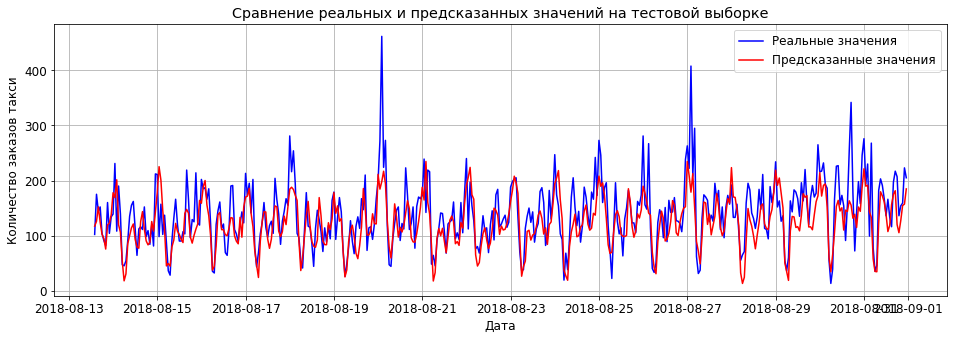

In [34]:
df = df1.copy()
make_features(99, 2)

train_features, train_target, _, _, test_features, test_target = df_split(df)

model = LinearRegression()
model.fit(train_features, train_target)

test_pred = model.predict(test_features)
        
print_info(test_target, test_pred)

Видим, что модель довольно точно предсказывает значения. Однако ошибается в прогнозе пиковых значений - сильно отличающихся от средних.

**RandomForestRegressor**

RMSE модели на тестовой выборке: 50.888628095576756


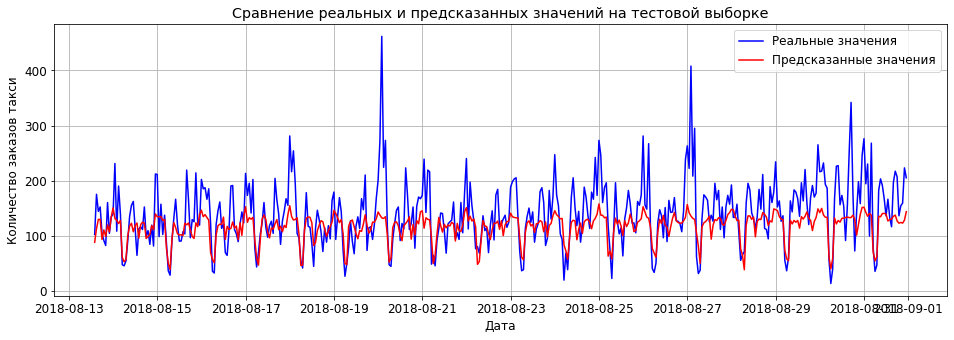

In [35]:
df = df1.copy()
make_features(97, 10)

train_features, train_target, _, _, test_features, test_target = df_split(df)

model = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=40)
model.fit(train_features, train_target)

test_pred = model.predict(test_features)
  
print_info(test_target, test_pred)

Модель почти всегда правильно предсказывает малые значения (меньше 100), а все, что больше 150 предсказывается с ошибкой.

**CatBoostRegressor**

RMSE модели на тестовой выборке: 53.27618979052537


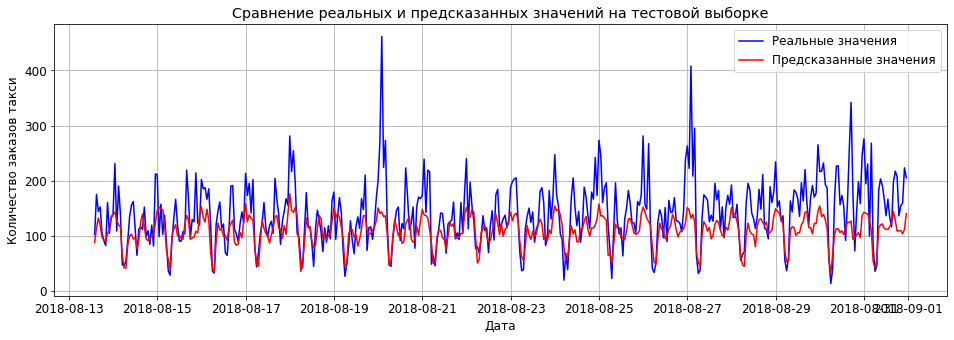

In [36]:
df = df1.copy()
make_features(109, 10)

train_features, train_target, _, _, test_features, test_target = df_split(df)
        
cat_features = ['month','day_of_week','day']

model = CatBoostRegressor(loss_function='MAE',
                          eval_metric='RMSE',
                          cat_features=cat_features,
                          depth=5,
                          iterations=1000,
                          verbose=False)

model.fit(train_features, train_target)
test_pred = model.predict(test_features)
         
print_info(test_target, test_pred)

Данная модель схожа с предыдущим случаем - почти всегда правильно предсказывает малые значения (меньше 100), а значения больше 150 - с ошибкой.

**Случайная модель (dummy-model)**

Сравним обученные нами модели со случайной. 

Случайная модель (dummy-model) предсказывает каждое значение константой, а именно средним значением.

RMSE модели на тестовой выборке: 84.74414402014742


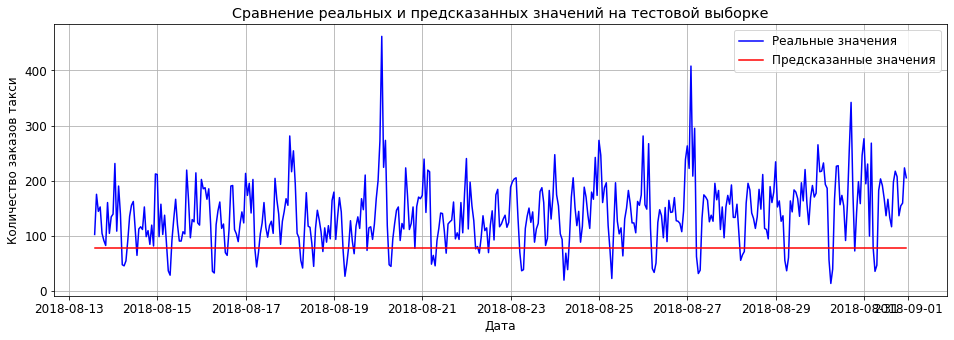

In [37]:
df = df1.copy()

train, test = train_test_split(df, shuffle=False, test_size=0.1)
        
pred_mean = pd.Series(train['num_orders'].mean(), index=test.index)
        
print_info(test['num_orders'], pred_mean)

Случайная модель заметно хуже - метрика RMSE всего 84.74.

Сведем полученные результаты в таблицу.

In [39]:
total_df = pd.DataFrame({'RMSE':[43.08, 50.89, 53.27, 84.74]}, 
                        index=['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'Dummy-model'])
total_df

,RMSE
LinearRegression,43.08
RandomForestRegressor,50.89
CatBoostRegressor,53.27
Dummy-model,84.74


**Вывод**

После проведение проверок моделей на тестовой выборке обнаружили, что только модель линейной регрессии достигла целевого значения метрики RMSE. На тестовых данных получили **RMSE = 43.08**. Цель работы достигнута.

Модели RandomForestRegressor и CatBoostRegressor, не смотря на то, что на валидационной выборке достигли целевого значения, на тестовых данных результаты показали хуже требуемого - **50.89 и 53.09, соответственно**. Улучшение метрики возможно путем более глубокого подбора гиперпараметров моделей или добавления дополнительных признаков в исследуемую выборку.